In [1]:
#https://github.com/chris-stellato/capstone3/tree/main/notebooks


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import math
import random
import os
import time
from tensorflow import keras

In [3]:
convert_to_dt = ['Date']

data = pd.read_csv('C:/Users/tomwr/Datasets/Tabular/tesco-stock.csv',
                   parse_dates = convert_to_dt,
                   infer_datetime_format = True
                  )
data_normal_index = data
data_date = data.set_index('Date')
print(data.head())
print()
print(data.info())

        Date        Open        High         Low       Close   Adj Close  \
0 2021-09-20  254.850006  255.751007  252.050003  254.449997  244.151596   
1 2021-09-21  255.550003  257.850006  254.750000  257.200012  246.790314   
2 2021-09-22  258.750000  261.649994  258.049988  261.649994  251.060181   
3 2021-09-23  263.500000  264.520996  259.500000  259.549988  249.045166   
4 2021-09-24  260.100006  260.500000  257.500000  257.500000  247.078156   

     Volume  
0  13732928  
1  18373464  
2  15194454  
3  13317828  
4   9898053  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       252 non-null    datetime64[ns]
 1   Open       252 non-null    float64       
 2   High       252 non-null    float64       
 3   Low        252 non-null    float64       
 4   Close      252 non-null    float64       
 5   Adj Close  252 non-n

In [4]:
#windowize function, three dimensional output for X and y, split afterwards
#the below windowize functions are imported but pasted here for working through setup
def windowize_data(data, n_prev, y_var, predict_steps=365):
    n_predictions = len(data) - n_prev
    
    print(f'num_predictions: {n_predictions}')
    y = data[y_var].iloc[n_prev:].values
    y_indices = np.arange(predict_steps) + np.arange(len(y) - predict_steps+1)[:, None] # (0 to 365) + (
    y = y[y_indices]
    x_indices = np.arange(n_prev) + np.arange(n_predictions- predict_steps+1)[:, None]
    x = data.values[x_indices]
    return x, y

In [5]:
n_prev = 25 # days behind
n_forecast = 10 # days forecast ahead

X, y = windowize_data(data, n_prev, 'Close', n_forecast)

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

num_predictions: 227
X shape: (218, 25, 7)
y shape: (218, 10)


In [21]:
WINDOW_SIZE = 10 #30
FORECAST_LEN = 5 #10

def windowize_data2(data, window_size, forecast_len, target):
    target_col = data[target]
    X = []
    y = []
    data_np = data.to_numpy()
    
    for i in range(len(data) - window_size): # for i in range (252 - 25 = 227)
        current_row_index = i - 1
        
        features = [[a] for a in data_np[i : i + window_size]] # row for row in data_numpy[1 : 1 + window_size]
        X.append(features)
        
        #labels = [[b] for b in target_col.iloc[i: i + window_size] in data[i: i + forecast_len]]
        
        #Labels need to be arrays for the next forecast_len values of data[target_col] for each row in data
        
        
        #y.append(labels)
        
    return np.array(X), np.array(y)

X2, y2 = windowize_data2(data_date, WINDOW_SIZE, FORECAST_LEN, 'Close')

In [7]:
print(X2.shape)
print(y2.shape)

(222, 30, 1, 6)
(0,)


In [8]:
print(data_date.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2021-09-20 to 2022-09-20
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       252 non-null    float64
 1   High       252 non-null    float64
 2   Low        252 non-null    float64
 3   Close      252 non-null    float64
 4   Adj Close  252 non-null    float64
 5   Volume     252 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.8 KB
None


In [22]:
#https://www.kaggle.com/code/rinichristy/bi-uni-lstm-rnns-for-temperature-forecasting
#assumes data has been scaled before this stage
def windowize_data3(data, window_size, forecast_len):
    X3 = []
    y3 = []
    for i in range(len(data) - window_size - forecast_len):
        X3.append(data[i: (i + window_size)])
        #y3.append(data[:, -1][i + window_size: i + window_size + forecast_len])
        
        y3.append(data[: -1][i + window_size: i + window_size + forecast_len])

    X3 = np.array(X3) #
    y3 = np.array(y3) #
    ry3 = y3[:, :, 3]
    return np.array(X3), np.array(y3), np.array(ry3)
    #ry3 = y3[:,:,3]
    #return np.array(ry3)
X3, y3, ry3 = windowize_data3(data_date, WINDOW_SIZE, FORECAST_LEN)

#print(X3.shape)
print(f'y3 shape: {y3.shape}') # Needs to be (212, 10) - 212 samples of the next 10 values of close.
print()
print()
print(f'ry3 shape: {ry3.shape}')
print()
print()
print(f'X3 shape: {X3.shape}')

#https://stackoverflow.com/questions/52572391/extract-nth-value-from-3d-array (for below)


y3 shape: (237, 5, 6)


ry3 shape: (237, 5)


X3 shape: (237, 10, 6)


In [23]:
print(X3[0])

#10 rows as windowsize = 10. 
#6 values in each as these are the columns.

[[2.54850006e+02 2.55751007e+02 2.52050003e+02 2.54449997e+02
  2.44151596e+02 1.37329280e+07]
 [2.55550003e+02 2.57850006e+02 2.54750000e+02 2.57200012e+02
  2.46790314e+02 1.83734640e+07]
 [2.58750000e+02 2.61649994e+02 2.58049988e+02 2.61649994e+02
  2.51060181e+02 1.51944540e+07]
 [2.63500000e+02 2.64520996e+02 2.59500000e+02 2.59549988e+02
  2.49045166e+02 1.33178280e+07]
 [2.60100006e+02 2.60500000e+02 2.57500000e+02 2.57500000e+02
  2.47078156e+02 9.89805300e+06]
 [2.58899994e+02 2.59950012e+02 2.57100006e+02 2.57899994e+02
  2.47461960e+02 1.60735510e+07]
 [2.56899994e+02 2.59000000e+02 2.54399994e+02 2.56350006e+02
  2.45974701e+02 1.45675030e+07]
 [2.56950012e+02 2.58899994e+02 2.56100006e+02 2.56500000e+02
  2.46118637e+02 2.43726390e+07]
 [2.58000000e+02 2.58700012e+02 2.52800003e+02 2.53300003e+02
  2.43048141e+02 2.52676980e+07]
 [2.51199997e+02 2.51600006e+02 2.46600006e+02 2.47949997e+02
  2.37914673e+02 2.41409030e+07]]


In [31]:
print(ry3[0])

#1 row = 1 row of outputs
#5 values in row = next 5 values of close.

[251.649994 253.       268.049988 273.149994 275.600006]


**Split data into train, val, test - 80: 10: 10**

In [41]:
print(len(X3))
print(len(ry3))
print()
print(f'80% of dataset: {(len(X3) / 100) * 80}')
print(f'90% of dataset: {(len(X3) / 100) * 90}')

X_train, y_train = X3[:190], ry3[:190]
X_val, y_val = X3[190: 214], ry3[190:214]
X_test, y_test = X3[214:], ry3[214:]

print()
print(f'X_train, y_train shapes: {X_train.shape, y_train.shape}')
print(f'X_val, y_val shapes: {X_val.shape, y_val.shape}')
print(f'X_test, y_test shapes: {X_test.shape, y_test.shape}')

237
237

80% of dataset: 189.60000000000002
90% of dataset: 213.3

X_train, y_train shapes: ((190, 10, 6), (190, 5))
X_val, y_val shapes: ((24, 10, 6), (24, 5))
X_test, y_test shapes: ((23, 10, 6), (23, 5))


In [42]:
from keras.models import Sequential
from keras.layers import *
from keras.activations import *
from keras.optimizers import *
from keras.losses import *
from keras.metrics import *
from keras.constraints import *

In [47]:
#This works but performs pretty poorly on unscaled data. 

lstm_1 = Sequential([
    LSTM(units = 64, input_shape = X3.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    LSTM(units = 64, return_sequences = False, kernel_constraint = NonNeg()),
    Dense(units = FORECAST_LEN, activation = 'linear', kernel_constraint = NonNeg())
    
])

lstm_1.compile(loss = 'mean_squared_error',
               optimizer = Adam(),
               metrics = RootMeanSquaredError()
              )

lstm_1_history = lstm_1.fit(X_train, y_train,
                            validation_data = (X_val, y_val),
                            epochs = 5
                           )


Epoch 1/5
6/6 [==============================] - 4s 169ms/step - loss: 74245.7500 - root_mean_squared_error: 272.4807 - val_loss: 65894.7812 - val_root_mean_squared_error: 256.6998
Epoch 2/5
6/6 [==============================] - 0s 14ms/step - loss: 73542.9531 - root_mean_squared_error: 271.1880 - val_loss: 65617.7500 - val_root_mean_squared_error: 256.1596
Epoch 3/5
6/6 [==============================] - 0s 13ms/step - loss: 73265.3984 - root_mean_squared_error: 270.6758 - val_loss: 65372.9062 - val_root_mean_squared_error: 255.6813
Epoch 4/5
6/6 [==============================] - 0s 13ms/step - loss: 73016.2734 - root_mean_squared_error: 270.2152 - val_loss: 65147.4531 - val_root_mean_squared_error: 255.2400
Epoch 5/5
6/6 [==============================] - 0s 13ms/step - loss: 72783.1484 - root_mean_squared_error: 269.7835 - val_loss: 64931.8594 - val_root_mean_squared_error: 254.8173


In [52]:
lstm_1_predictions = lstm_1.predict(X_test)

print(len(lstm_1_predictions))
print()
print(lstm_1_predictions)

#Each row in predictions of all 4 is days +1, +2, +3 etc. 

1/1 [==============================] - 0s 18ms/step
23

[[6.282501  8.02745   6.3229275 6.4182267 7.1905336]
 [6.282501  8.02745   6.3229275 6.4182267 7.1905336]
 [6.282501  8.02745   6.3229275 6.4182267 7.1905336]
 [6.2825017 8.02745   6.3229275 6.4182267 7.1905336]
 [6.2825017 8.02745   6.3229275 6.4182267 7.1905336]
 [6.2825017 8.02745   6.3229275 6.4182267 7.1905336]
 [6.282501  8.02745   6.3229275 6.4182267 7.1905336]
 [6.282501  8.02745   6.3229275 6.4182267 7.1905336]
 [6.282501  8.02745   6.3229275 6.4182267 7.1905336]
 [6.2825017 8.02745   6.3229275 6.4182267 7.1905336]
 [6.282501  8.02745   6.3229275 6.4182267 7.1905336]
 [6.282501  8.02745   6.3229275 6.4182267 7.1905336]
 [6.282501  8.02745   6.3229275 6.4182267 7.1905336]
 [6.282501  8.02745   6.3229275 6.4182267 7.1905336]
 [6.282501  8.02745   6.3229275 6.4182267 7.1905336]
 [6.2825017 8.02745   6.3229275 6.4182267 7.190534 ]
 [6.282501  8.02745   6.3229275 6.4182267 7.190534 ]
 [6.282501  8.02745   6.3229275 6.4182267 7

**Scaling the data for better performance (hopefully)**

In [61]:
from sklearn.preprocessing import MinMaxScaler

feature_scaler = MinMaxScaler(feature_range = (0, 1))


label_scaler = MinMaxScaler(feature_range = (0, 1))

################## FEATURES ###########################
#Break down arrays shapes
X_train_sequences, X_train_window, X_train_features = X_train.shape
X_val_sequences, X_val_window, X_val_features = X_val.shape
X_test_sequences, X_test_window, X_test_features = X_test.shape

#Create 2D versions - so can be transformed
X_train_2D = X_train.reshape(X_train_sequences, X_train_window * X_train_features)
X_val_2D = X_val.reshape(X_val_sequences, X_val_window * X_val_features)
X_test_2D = X_test.reshape(X_test_sequences, X_test_window * X_test_features)

#Create 2D scaled versions
X_train_2D_scaled = feature_scaler.fit_transform(X_train_2D)
X_val_2D_scaled = feature_scaler.transform(X_val_2D)
X_test_2D_scaled = feature_scaler.transform(X_test_2D)

#Create 3D scaled versions - so can be used in a model
X_train_3D_scaled = X_train_2D_scaled.reshape(X_train_sequences, X_train_window, X_train_features)
X_val_3D_scaled = X_val_2D_scaled.reshape(X_val_sequences, X_val_window, X_val_features)
X_test_3D_scaled = X_test_2D_scaled.reshape(X_test_sequences, X_test_window, X_test_features)

################## LABELS ##############################

#Create scaled 2D labels - y_train is already 2D
y_train_2D_scaled = label_scaler.fit_transform(y_train)
y_val_2D_scaled = label_scaler.transform(y_val)
y_test_2D_scaled = label_scaler.transform(y_test)

#Create scaled 1D labels
y_train_1D_scaled = y_train_2D_scaled.flatten()
y_val_1D_scaled = y_val_2D_scaled.flatten()
y_test_1D_scaled = y_test_2D_scaled.flatten()

#Create unscaled 1D labels
y_train_1D_unscaled = label_scaler.inverse_transform(y_train_2D_scaled).flatten()
y_val_1D_unscaled = label_scaler.inverse_transform(y_val_2D_scaled).flatten()
y_test_1D_unscaled = label_scaler.inverse_transform(y_test_2D_scaled).flatten()

(190, 5)


**LSTM_2 - Using same architecture but scaled dataset**

In [63]:
lstm_2 = Sequential([
    LSTM(units = 64, input_shape = X3.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    LSTM(units = 64, return_sequences = False, kernel_constraint = NonNeg()),
    Dense(units = FORECAST_LEN, activation = 'linear', kernel_constraint = NonNeg())
    
])

lstm_2.compile(loss = 'mean_squared_error',
               optimizer = Adam(),
               metrics = RootMeanSquaredError()
              )

lstm_2_history = lstm_2.fit(X_train_3D_scaled, y_train_2D_scaled,
                            validation_data = (X_val_3D_scaled, y_val_2D_scaled),
                            epochs = 20
                           )

Epoch 1/20
6/6 [==============================] - 4s 170ms/step - loss: 0.2950 - root_mean_squared_error: 0.5431 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0633
Epoch 2/20
6/6 [==============================] - 0s 14ms/step - loss: 0.0255 - root_mean_squared_error: 0.1596 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1054
Epoch 3/20
6/6 [==============================] - 0s 13ms/step - loss: 0.0500 - root_mean_squared_error: 0.2236 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1231
Epoch 4/20
6/6 [==============================] - 0s 13ms/step - loss: 0.0472 - root_mean_squared_error: 0.2173 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0907
Epoch 5/20
6/6 [==============================] - 0s 13ms/step - loss: 0.0250 - root_mean_squared_error: 0.1580 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0451
Epoch 6/20
6/6 [==============================] - 0s 13ms/step - loss: 0.0167 - root_mean_squared_error: 0.1293 - val_loss: 0.0015 - val_root_mean_squared

1/1 [==============================] - 0s 18ms/step

(23, 5)
23
[[0.3051116  0.30273694 0.30122453 0.31085125 0.30569008]
 [0.31308562 0.31022388 0.30967182 0.31838578 0.31336215]
 [0.32202542 0.31868422 0.31908768 0.32687855 0.32197842]
 [0.32167044 0.31866848 0.31807405 0.32681873 0.3215994 ]
 [0.3229785  0.3199981  0.31915525 0.3282776  0.32288563]
 [0.33048302 0.32684332 0.32768294 0.3356061  0.3304141 ]
 [0.3445117  0.339975   0.3431845  0.3493412  0.34430608]
 [0.36365503 0.35800666 0.36423922 0.3682181  0.3632676 ]
 [0.38380116 0.3773151  0.38537607 0.38767436 0.38255677]
 [0.39612657 0.3897934  0.39678508 0.39968884 0.3938645 ]
 [0.39516369 0.39020923 0.3930959  0.39946854 0.39237824]
 [0.3813997  0.3784643  0.37574178 0.38662237 0.37826112]
 [0.35192555 0.35177052 0.34141308 0.35819983 0.34859398]
 [0.31335527 0.31624115 0.29762062 0.32065684 0.31027952]
 [0.26858288 0.27411968 0.2490415  0.27676845 0.26659995]
 [0.22827248 0.23508938 0.2079338  0.23641557 0.22788581]
 [0.1820

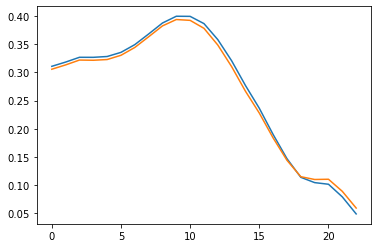

In [81]:
lstm_2_predictions = lstm_2.predict(X_test_3D_scaled)
print()
print(lstm_2_predictions.shape) # (23, 5) is same shape as y test.

#23 days of +5 forecasts. Each row is next day.
#Bottom row is predictions beyond the end of dataset ( i think)

print(len(lstm_2_predictions))

print(lstm_2_predictions)

lstm_2_predictions_5day = lstm_2_predictions[:, 3:5]
plt.plot(lstm_2_predictions_5day)

#plt.plot(lstm_2_predictions[-2]) # 2nd from bottom row - Blue
#plt.plot(lstm_2_predictions[-1]) # bottom row - Orange
#plt.plot(lstm_2_predictions)
plt.show()